## Using the dataset, build a model that can forecast ticket volume

In [1]:
# basic packages
import numpy as np
import pandas as pd
import warnings
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split, cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
#data specific package
from pandas.tseries.holiday import USFederalHolidayCalendar

warnings.filterwarnings(
    action="ignore"
)

In [2]:
# importing dataset
df = pd.read_csv("Data/MR_DS.csv")

# data start and end date
start_date = '2015-11-24'
end_date = '2016-04-21'

In [3]:
df.head()

,Ticket Created Date,Total Tickets Opened,Subscription Order Count,Non Subscription Order Count,Subscription Customer Count,Non Subscription Customer Count
0,4/21/2016,533,984,507,239,240
1,4/20/2016,658,6035,485,225,210
2,4/19/2016,778,2450,500,196,231
3,4/18/2016,743,2502,527,192,240
4,4/17/2016,925,3080,488,217,209


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
Ticket Created Date                150 non-null object
Total Tickets Opened               150 non-null int64
Subscription Order Count           150 non-null int64
Non Subscription Order Count       150 non-null int64
Subscription Customer Count        150 non-null int64
Non Subscription Customer Count    150 non-null int64
dtypes: int64(5), object(1)
memory usage: 7.1+ KB


In [5]:
# convert date to datetime object to apply transformations
df["Ticket Created Date"] = pd.to_datetime(df["Ticket Created Date"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
Ticket Created Date                150 non-null datetime64[ns]
Total Tickets Opened               150 non-null int64
Subscription Order Count           150 non-null int64
Non Subscription Order Count       150 non-null int64
Subscription Customer Count        150 non-null int64
Non Subscription Customer Count    150 non-null int64
dtypes: datetime64[ns](1), int64(5)
memory usage: 7.1 KB


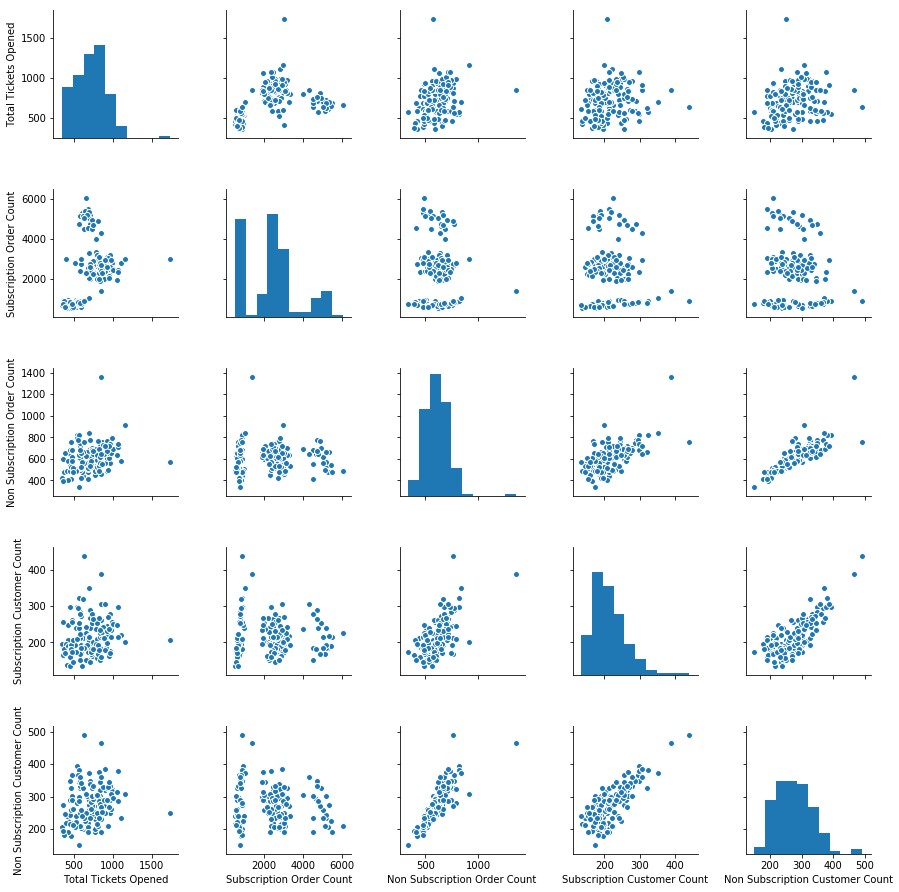

In [6]:
sns.pairplot(df)

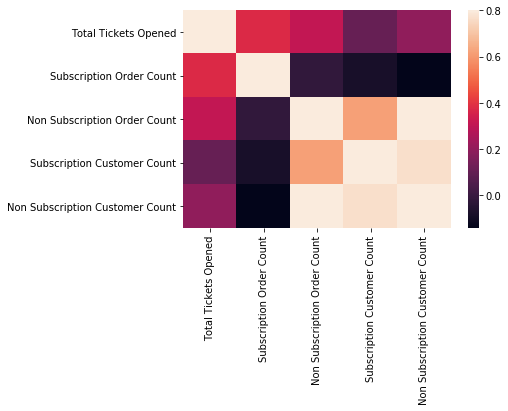

In [7]:
sns.heatmap(df.corr(), vmax=.8)

In [8]:
np.argmax(df["Total Tickets Opened"])

25

In [9]:
# dropping outlier of total tickets opened and also reducing correlated variables
df = df.drop(df.index[25])
df = df.drop(["Subscription Customer Count", "Non Subscription Customer Count"], axis=1)

In [10]:
# create season feature: winter, spring, summer, fall
df["Season"] = "Winter"
df["Season"][(df["Ticket Created Date"].dt.month > 2) & (df["Ticket Created Date"].dt.month <= 5)]  = "Spring"
df["Season"][(df["Ticket Created Date"].dt.month > 5) & (df["Ticket Created Date"].dt.month <= 8)]  = "Summer"
df["Season"][(df["Ticket Created Date"].dt.month > 8) & (df["Ticket Created Date"].dt.month <= 11)]  = "Fall"
df.Season.unique()

array(['Spring', 'Winter', 'Fall'], dtype=object)

In [11]:
# linear model doesn't accept categories, one hot encoding to accommodate
one_hot = pd.get_dummies(df["Season"])
df = df.drop("Season", axis=1)
df = df.join(one_hot)

In [12]:
# create holiday feature
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start=start_date, end=end_date)
df["Holiday"] = np.where(df["Ticket Created Date"].isin(holidays), "Holiday", "Not Holiday")
list(holidays)

[Timestamp('2015-11-26 00:00:00'),
 Timestamp('2015-12-25 00:00:00'),
 Timestamp('2016-01-01 00:00:00'),
 Timestamp('2016-01-18 00:00:00'),
 Timestamp('2016-02-15 00:00:00')]

In [13]:
one_hot = pd.get_dummies(df["Holiday"])
df = df.drop("Holiday", axis=1)
df = df.join(one_hot)

In [14]:
# check weekday vs weekend
df["Weekday"] = np.where(pd.DatetimeIndex(df["Ticket Created Date"]).weekday < 5, "Weekday", "Weekend")
df.head()

,Ticket Created Date,Total Tickets Opened,Subscription Order Count,Non Subscription Order Count,Fall,Spring,Winter,Holiday,Not Holiday,Weekday
0,2016-04-21,533,984,507,0,1,0,0,1,Weekday
1,2016-04-20,658,6035,485,0,1,0,0,1,Weekday
2,2016-04-19,778,2450,500,0,1,0,0,1,Weekday
3,2016-04-18,743,2502,527,0,1,0,0,1,Weekday
4,2016-04-17,925,3080,488,0,1,0,0,1,Weekend


In [15]:
one_hot = pd.get_dummies(df["Weekday"])
df = df.drop("Weekday", axis=1)
df = df.join(one_hot)

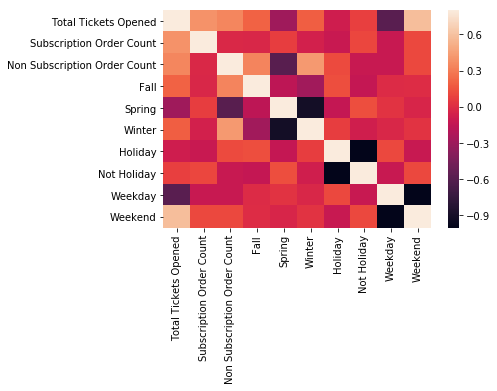

In [16]:
# check for correlation
sns.heatmap(df.corr(), vmax=0.8)

In [17]:
# original algorithm without any reduction
rgr = LinearRegression()
Y = df["Total Tickets Opened"]
X = df.iloc[:, 2:]

# splitting dataset into training data and testing data to validate model using holdout groups
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

rgr.fit(X_train, Y_train)

print('\nCoefficients: \n', rgr.coef_)
print('\nIntercept: \n', rgr.intercept_)
print('\nAccuracy:\n', rgr.score(X_train, Y_train))


Coefficients: 
 [ 4.42710400e-02  2.69947813e-01  1.16153674e+02 -9.07358021e+01
 -2.54178718e+01 -4.71660775e+01  4.71660775e+01 -9.76468031e+01
  9.76468031e+01]

Intercept: 
 483.5193097654266

Accuracy:
 0.5441264430972625


In [18]:
print('\nCross Validation of test data:\n',cross_val_score(rgr, X_test, Y_test, cv=3))
print('\nCross Validation of entire data:\n',cross_val_score(rgr, X, Y, cv=3))


Cross Validation of test data:
 [0.54585108 0.16181794 0.70112379]

Cross Validation of entire data:
 [-0.17265993  0.33904858  0.26636724]


In [19]:
# try to simplify equation based on correlation heatmap; keeping all seasons
X = df[["Subscription Order Count", "Non Subscription Order Count", "Fall", "Spring", "Winter", "Holiday", "Weekday"]]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)
rgr.fit(X_train, Y_train)

print('\nCoefficients: \n', rgr.coef_)
print('\nIntercept: \n', rgr.intercept_)
print('\nAccuracy:\n', rgr.score(X_train, Y_train))


Coefficients: 
 [ 4.46756399e-02  1.21201119e-01  1.08266156e+02 -7.84849313e+01
 -2.97812245e+01 -4.17278022e+01 -2.24514851e+02]

Intercept: 
 735.0275736100701

Accuracy:
 0.6128439950944586


In [20]:
print('\nCross Validation of test data:\n',cross_val_score(rgr, X_test, Y_test, cv=3))
print('\nCross Validation of entire data:\n',cross_val_score(rgr, X, Y, cv=3))


Cross Validation of test data:
 [0.43360159 0.29012693 0.37270778]

Cross Validation of entire data:
 [-0.17265993  0.33904858  0.26636724]


In [21]:
# save to dataset
df.to_csv("Data/Modified_MR_DS.csv")

In [22]:
# instead of weekday v weekend, check day
df = df.drop(['Weekday', 'Weekend'], axis=1)

In [23]:
df['Day of Week'] = pd.DatetimeIndex(df["Ticket Created Date"]).weekday
df['Day of Week'] = df['Day of Week'].where(df['Day of Week'] != 6, 'Sunday')
df['Day of Week'] = df['Day of Week'].where(df['Day of Week'] != 5, 'Saturday')
df['Day of Week'] = df['Day of Week'].where(df['Day of Week'] != 4, 'Friday')
df['Day of Week'] = df['Day of Week'].where(df['Day of Week'] != 3, 'Thursday')
df['Day of Week'] = df['Day of Week'].where(df['Day of Week'] != 2, 'Wednesday')
df['Day of Week'] = df['Day of Week'].where(df['Day of Week'] != 1, 'Tuesday')
df['Day of Week'] = df['Day of Week'].where(df['Day of Week'] != 0, 'Monday')

In [24]:
one_hot = pd.get_dummies(df["Day of Week"])
df = df.drop("Day of Week", axis=1)
df = df.join(one_hot)
df.head()

,Ticket Created Date,Total Tickets Opened,Subscription Order Count,Non Subscription Order Count,Fall,Spring,Winter,Holiday,Not Holiday,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,2016-04-21,533,984,507,0,1,0,0,1,0,0,0,0,1,0,0
1,2016-04-20,658,6035,485,0,1,0,0,1,0,0,0,0,0,0,1
2,2016-04-19,778,2450,500,0,1,0,0,1,0,0,0,0,0,1,0
3,2016-04-18,743,2502,527,0,1,0,0,1,0,1,0,0,0,0,0
4,2016-04-17,925,3080,488,0,1,0,0,1,0,0,0,1,0,0,0


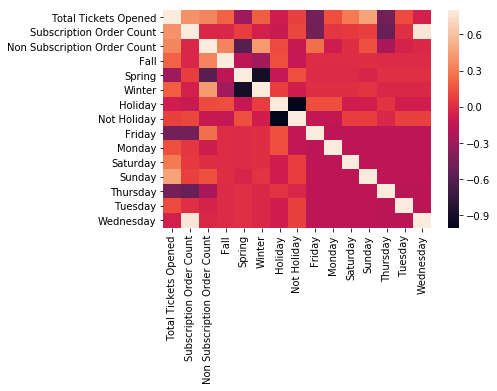

In [25]:
# check for correlation
sns.heatmap(df.corr(), vmax=0.8)

In [26]:
# since comparing each day, also remove season, since there is only partial fall data and no summer data
X = df[["Subscription Order Count", "Non Subscription Order Count", "Holiday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)
rgr.fit(X_train, Y_train)

print('\nCoefficients: \n', rgr.coef_)
print('\nIntercept: \n', rgr.intercept_)
print('\nAccuracy:\n', rgr.score(X_train, Y_train))


Coefficients: 
 [-2.80234009e-02  5.64183747e-01 -2.63633155e+01  8.99063310e+01
  6.72796271e+01  5.38303180e+01 -2.13483603e+02 -2.93536487e+02
  1.20668067e+02  1.75335747e+02]

Intercept: 
 437.0748009684069

Accuracy:
 0.7602386479587114


In [27]:
print('\nCross Validation of test data:\n',cross_val_score(rgr, X_test, Y_test, cv=3))
print('\nCross Validation of entire data:\n',cross_val_score(rgr, X, Y, cv=3))


Cross Validation of test data:
 [0.6618525  0.77031958 0.82310427]

Cross Validation of entire data:
 [0.58621973 0.79030057 0.67035769]


In [28]:
# day of week is more accurate than weekday & weekend. keep day of week
df.to_csv("Data/Modified_Days_MR_DS.csv")

In [29]:
las = Lasso()
las.fit(X_train, Y_train)

print('\nCoefficients: \n', las.coef_)
print('\nIntercept: \n', las.intercept_)
print('\nAccuracy:\n', las.score(X_train, Y_train))


Coefficients: 
 [-1.24351959e-02  5.62902119e-01 -0.00000000e+00  1.30773867e+01
  0.00000000e+00 -4.50516184e+01 -2.45889388e+02 -3.30132591e+02
  4.13208352e+01  9.72198908e+01]

Intercept: 
 466.4202124327342

Accuracy:
 0.7576405375357422


In [30]:
print('\nCross Validation of test data:\n',cross_val_score(las, X_test, Y_test, cv=3))
print('\nCross Validation of entire data:\n',cross_val_score(las, X, Y, cv=3))


Cross Validation of test data:
 [0.66651811 0.76405392 0.81308422]

Cross Validation of entire data:
 [0.57783453 0.80195696 0.62751027]


In [31]:
rid = Ridge()
rid.fit(X_train, Y_train)

print('\nCoefficients: \n', rid.coef_)
print('\nIntercept: \n', rid.intercept_)
print('\nAccuracy:\n', rid.score(X_train, Y_train))


Coefficients: 
 [ 2.01733432e-02  5.63185027e-01 -2.20815295e+01  7.87434476e+01
  6.07903911e+01 -6.22120646e+01 -1.22765920e+02 -2.04692038e+02
  9.75266866e+01  1.52609497e+02]

Intercept: 
 321.0612445968316

Accuracy:
 0.751046509372648


In [32]:
print('\nCross Validation of test data:\n',cross_val_score(rid, X_test, Y_test, cv=3))
print('\nCross Validation of entire data:\n',cross_val_score(rid, X, Y, cv=3))


Cross Validation of test data:
 [0.68826866 0.79486644 0.7301869 ]

Cross Validation of entire data:
 [0.56229976 0.81383023 0.62165845]
